In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Reading Names Dataset
print(f"Working dir: {os.getcwd()}")
dataset_path = os.path.join(os.getcwd(), "../makemore/names.txt")
words = open(dataset_path, 'r').read().splitlines()

Working dir: /Users/tomery/Library/CloudStorage/OneDrive-Mobileye/Documents/training_repos/zero_to_hero/exercises


In [22]:
# Exploring Dataset
print(f"first 10 words{words[:10]}")
print(f"length of words: {len(words)}")
print(f"min word length {min(len(w) for (w) in words)} and max word length {max(len(w) for (w) in words)}")

first 10 words['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
length of words: 32033
min word length 2 and max word length 15


In [23]:
# Make a list of characters (a -> z)
# Adding '.' as a word starter.
chars = sorted(list(set(''.join(words))))

# bi string to index as an input - 2 characters.
combinations_in_bigram = [ch1 + ch2 for ch1 in chars for ch2 in chars]

# Make a dictionary of character to index
bi_stoi = {s: i+len(chars) for i, s in enumerate(combinations_in_bigram)} 

for i in range(len(chars)):
    bi_stoi['.'+chars[i]] =  i 

# single string to index
si_stoi = {s:i+1 for i,s in enumerate(chars)} 
si_stoi['.'] = 0

# Index to string:
bi_itos = {i:s for s,i in bi_stoi.items()}
si_itos = {i:s for s,i in si_stoi.items()}

## Statistics approach (using counting):

In [24]:
# All combinations counter:
# N gather all the possible bi-characters with the correspond next single character in the dataset, and put them with index.
# Makes a trigram 2characters + next 1character as a label.
# '.' use for end / start of a word character.
N = torch.zeros((27*27, 27), dtype=torch.int32, device=device)

# Getting the Bigrams
for w in words:
  chs = ['.'] + list(w) + ['.']
  
  for i in range(len(chs) - 2):  
    ch1_2 = chs[i] + chs[i + 1]  
    ch3 = chs[i + 2] 
    
    ix1 = bi_stoi[ch1_2]
    ix2 = si_stoi[ch3]
    
    N[ix1, ix2] += 1
    
P = (N+1).float()
P /= P.sum(1, keepdims=True)

### Visualize the data:

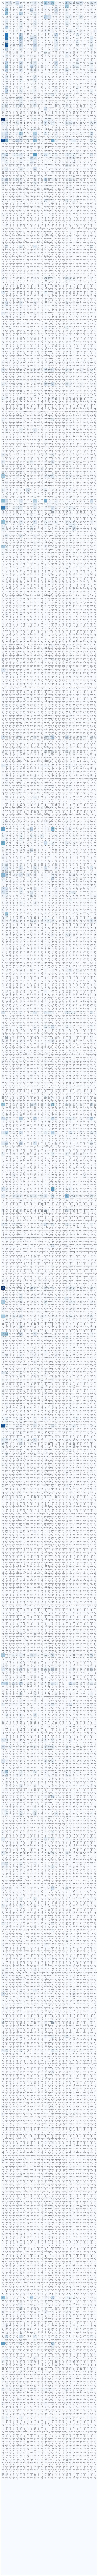

In [25]:
plt.figure(figsize=(300,300))
plt.imshow(N, cmap='Blues')

for i in range(len(bi_itos)):
    for j in range(len(si_itos)):
        chstr = bi_itos[i] + si_itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [20]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [26]:
def count_loss(input_list=list):
  log_likelihood = 0.0
  n = 0

  for w in input_list:
  #for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.']
    
    for i in range(len(chs) - 2):  
      ch1_2 = chs[i] + chs[i + 1]  
      ch3 = chs[i + 2] 
      
      ix1 = bi_stoi[ch1_2]
      ix2 = si_stoi[ch3]
      
      prob = P[ix1, ix2]
      logprob = torch.log(prob)
      log_likelihood += logprob
      n += 1

  print(f'log_likelihood = {log_likelihood}')
  nll = -log_likelihood
  print(f'Negative log likelihood = {nll}')
  print(f'"Normalized Negative log Likelihood = {nll/n}')
  
print("Training Loss:")
count_loss(words)

Training Loss:
log_likelihood = -410414.96875
Negative log likelihood = 410414.96875
"Normalized Negative log Likelihood = 2.092747449874878


### Sampling Inference:

In [27]:
g = torch.Generator().manual_seed(2147483147)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(si_itos[ix])
    
    if si_itos[ix] == '.':
      break
  print(''.join(out))

veruiaaertraoruaearaeralartcereraereariaarhlarcuaeieiaeoearhroeoaeieiiaaroayararalyaeaaorhsyorarhlalyareeeriariiarihsriaroraiaeearaerhtrhseraaeeuiuiartnluaiorioaeiaaeloararhtyhdsrhnnleararhseieaeeliaeiarhnseiohrwaraaeaealaeoaralarawznzrhlaeartseaeorararhseiewfohgaaryyyaeaeiaeaearhdlearhsaaoortzzdliaerkorhsraiorlcaoraeoioaaarmioraroeeroraoeleaearaoekearaoaararpdaercaraerkiareaierhzrnliarararnzmyartloraruiaelohleoryareiareaaeeiuaeoefleaaroioarhncertlceeoaoariarhlarhrhsiareareraaaeeerarhnlaleaanndlartlerhsrhviaroearaaaiarhrarhsaloxuieaaeraelelaearhxaraeeareiarhmhdmeaeiaearhrtuiorhsiiiarhyiesaaleiojaleaariarooraaeearhrhvhsaaihsararhsiaroariaruauerooeaeliooraraoeiartcaroeelaeaefariarkoriohrohkaealiiaartmiararhviaraeiaaearueartluaarhndlariaeeaaeaeliearheaortteruiaarrieiaoaatraajaroeooalarioaererioaraeyaarhrhsyaeloalewerharhzddsoroearruiartznznwiaxuelortxuierlohkieierhlarhviorarararaeararueaaareariarhrarbhvaartriaarlerebaeaiaalalaererearaxuznliarkaraqhnsrhnliewyariararalarieiohznrerarhkeararr

## Second approach - Train on layer net:


In [10]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  
  for i in range(len(chs) - 2):  
    ch1_2 = chs[i] + chs[i + 1]  
    ch3 = chs[i + 2] 
    
    ix1 = bi_stoi[ch1_2]
    ix2 = si_stoi[ch3]
  
    print(ch1_2, ch3)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

.e m
em m
mm a
ma .


### Training with gradient descent:

In [16]:
W = torch.randn((len(N), 27), generator=g, requires_grad=True)

ephocs = 100
for k in range(ephocs):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=len(N)).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(len(xs)), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad




3.9558465480804443
0.010289459489285946
0.010287914425134659
0.010286342352628708
0.01028474047780037
0.01028322521597147
0.010281695984303951
0.01028006337583065
0.01027856394648552
0.010277005843818188
0.010275489650666714
0.01027395948767662
0.01027246005833149
0.010270914994180202
0.010269427672028542
0.010267884470522404
0.010266412049531937
0.010264954529702663
0.010263453237712383
0.010262012481689453
0.010260495357215405
0.01025899313390255
0.01025755051523447
0.010256136767566204
0.010254680179059505
0.010253236629068851
0.01025182381272316
0.010250350460410118
0.01024889200925827
0.010247508063912392
0.010246078483760357
0.010244665667414665
0.010243279859423637
0.010241835378110409
0.010240377858281136
0.010239021852612495
0.010237605310976505
0.010236222296953201
0.010234850458800793
0.010233482345938683
0.010232064872980118
0.010230679996311665
0.010229322127997875
0.01022795308381319
0.010226581245660782
0.010225254110991955
0.010223898105323315
0.0102225411683321
0.01022

### Sampling Inference and loss:

In [19]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  
  while True:
    # ----------
    # When Counting:
    #p = P[ix]
    # ----------
    
    # now we use the softmax of the logits
    xenc = F.one_hot(torch.tensor([ix]), num_classes=len(N)).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(si_itos[ix])
    if ix == 0:
      break
  print(''.join(out))
  
print("\nTraining Loss:")
count_loss(words)

dmxzedmdmlkurkwcqzktxhkwstzymjtnaitrlgfakzkhtuwkskmxypubptvhrggltzs.
iozyeqckxujjwgtedmakklevkmcskdmuhtkgvgfnywftlspwhucjmngvtahtvsk.
ysfcxdmngslhpfnwuiqbnxwnrzywnmkwkwmkwesu.
fkxmt.
gcckgjbpuhbsvatubmuyexqevacmabxmcmahurwncvxmvpfkllmdmavjzsobdmcsoe.

Training Loss:
log_likelihood = -410414.96875
Negative log likelihood = 410414.96875
"Normalized Negative log Likelihood = 2.092747449874878
